# Posterior distribution and point prediction

In [2]:
import numpy as np

posterior_distribution = np.random.lognormal(0, .25, 10000) * 50000
posterior_distribution = posterior_distribution * 50000 / np.mean(posterior_distribution)
point_prediction = np.mean(posterior_distribution)
error = point_prediction - posterior_distribution
mean_abs_error = np.mean(np.abs(posterior_distribution - point_prediction))

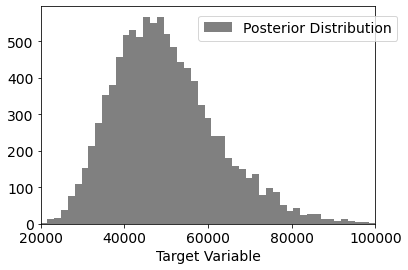

In [5]:
import matplotlib.pyplot as plt

f, ax = plt.subplots()

ax.hist(posterior_distribution, bins=np.linspace(20_000, 100_000, 50), color='grey', label='Posterior Distribution')
ax.set_xlabel('Target Variable', fontsize=14)

ax.set_xlim(20000, 100000)

ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)

ax.legend(fontsize=14, loc='center left', bbox_to_anchor=(.45, .9))

f.savefig('posterior.png', dpi=200, bbox_inches='tight')

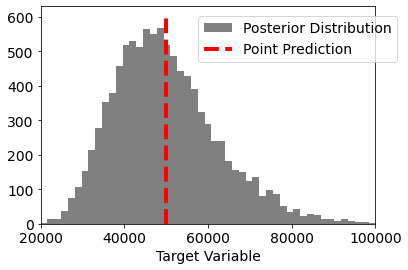

In [7]:
f, ax = plt.subplots()

ax.hist(posterior_distribution, bins=np.linspace(20_000, 100_000, 50), color='grey', label='Posterior Distribution')
ax.vlines(point_prediction, 0, 600, ls='--', lw=4, color='red', label='Point Prediction')
ax.set_xlabel('Target Variable', fontsize=14)

ax.set_xlim(20000, 100000)

ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
ax.legend(fontsize=14, loc='center left', bbox_to_anchor=(.45, .85))

f.savefig('posterior_and_point.png', dpi=200, bbox_inches='tight')

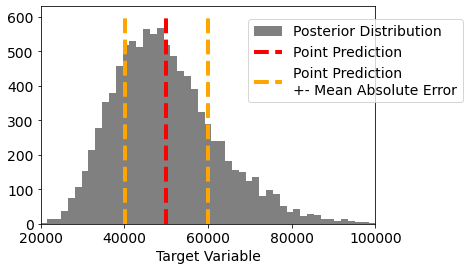

In [8]:
f, ax = plt.subplots()

ax.hist(posterior_distribution, bins=np.linspace(20_000, 100_000, 50), color='grey', label='Posterior Distribution')
ax.vlines(point_prediction, 0, 600, ls='--', lw=4, color='red', label='Point Prediction')
ax.vlines(point_prediction + mean_abs_error, 0, 600, ls='--', lw=4, color='orange', label='Point Prediction\n+- Mean Absolute Error')
ax.vlines(point_prediction - mean_abs_error, 0, 600, ls='--', lw=4, color='orange')

ax.set_xlabel('Target Variable', fontsize=14)

ax.set_xlim(20000, 100000)

ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
ax.legend(loc='center left', bbox_to_anchor=(.6, .75), fontsize=14)

f.savefig('posterior_and_point_and_error.png', dpi=200, bbox_inches='tight')

# Superconductor dataset

In [9]:
import pandas as pd

df = pd.read_csv('/kaggle/input/superconductor-dataset/train.csv').sample(frac=1, random_state=123)

df_train = df.iloc[:int(len(df)/5)]
df_valid = df.iloc[int(len(df)/5):int(len(df)/5*2)]
df_test = df.iloc[int(len(df)/5*2):]

X_train = df_train.drop('critical_temp', axis=1)
X_valid = df_valid.drop('critical_temp', axis=1)
X_test = df_test.drop('critical_temp', axis=1)
  
y_train = df_train['critical_temp']
y_valid = df_valid['critical_temp']
y_test = df_test['critical_temp']

In [10]:
from lightgbm import LGBMRegressor

model = LGBMRegressor().fit(X=X_train,y=y_train)

In [11]:
pred_valid = pd.Series(model.predict(X_valid), index=X_valid.index).clip(0)
error_valid = pred_valid - y_valid

In [12]:
model_abs_error = LGBMRegressor().fit(
  X=pd.concat([X_valid, pred_valid], axis=1),
  y=error_valid.abs()
)

model_error = LGBMRegressor().fit(
  X=pd.concat([X_valid, pred_valid], axis=1),
  y=error_valid
)

model_sq_error = LGBMRegressor().fit(
  X=pd.concat([X_valid, pred_valid], axis=1),
  y=error_valid ** 2
)

In [13]:
pred_test = pd.Series(model.predict(X_test), index=X_test.index).clip(0)
pred_error_test = pd.Series(model_error.predict(pd.concat([X_test, pred_test], axis=1)), index=X_test.index)
pred_abs_error_test = pd.Series(model_abs_error.predict(pd.concat([X_test, pred_test], axis=1)), index=X_test.index)
pred_sq_error_test = pd.Series(model_sq_error.predict(pd.concat([X_test, pred_test], axis=1)), index=X_test.index)

In [14]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

def get_metrics(y_pred, y_true=None, error=None, abs_error=None, sq_error=None):
  if y_true is not None:
    return pd.Series({
      'mae': mean_absolute_error(y_true, y_pred),
      'mse': mean_squared_error(y_true, y_pred)
    })
  else:
    abs_error = abs_error if abs_error is not None else np.abs(error)
    sq_error = sq_error if sq_error is not None else np.abs(error)
    return pd.Series({
      'mae': np.mean(abs_error),
      'mse': np.mean(sq_error)
    })

In [15]:
np.random.seed(123)

metrics_log = pd.DataFrame()

metrics_valid = get_metrics(y_true=y_valid, y_pred=pred_valid)

for ix, i in zip(
  np.random.permutation(np.array_split(pred_test.sort_values().index, 10)),
  #np.array_split(pred_produ_full.index, 5),
  range(10)):
  
  metrics_true_test = get_metrics(y_true=y_test.loc[ix], y_pred=pred_test.loc[ix])
  metrics_pred_error_test = get_metrics(y_pred=pred_test.loc[ix], error=pred_error_test.loc[ix])
  metrics_pred_serror_test = get_metrics(y_pred=pred_test.loc[ix], abs_error=pred_abs_error_test.loc[ix], sq_error=pred_sq_error_test.loc[ix])

  metrics_log.loc[i, ['valid_mae', 'valid_mse']] = metrics_valid.loc[['mae', 'mse']].tolist()
  metrics_log.loc[i, ['true_mae', 'true_mse']] = metrics_true_test.loc[['mae', 'mse']].tolist()
  metrics_log.loc[i, ['pred_e_mae', 'pred_e_mse']] = metrics_pred_error_test.loc[['mae', 'mse']].tolist()
  metrics_log.loc[i, ['pred_se_mae', 'pred_se_mse']] = metrics_pred_serror_test.loc[['mae', 'mse']].tolist()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


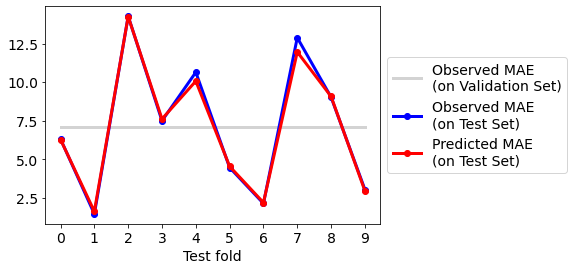

In [16]:
import matplotlib.pyplot as plt

f, ax = plt.subplots()

ax.plot(metrics_log['valid_mae'], label='Observed MAE\n(on Validation Set)', lw=3, color='lightgrey')
ax.plot(metrics_log['true_mae'], 'o-', label='Observed MAE\n(on Test Set)', lw=3, color='blue')
ax.plot(metrics_log['pred_se_mae'], 'o-', label='Predicted MAE\n(on Test Set)', lw=3, color='red')


ax.set_xticks(range(10))
ax.set_xlabel('Test fold', fontsize=14)

ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14)

f.savefig('mae_obs_vs_pred.png', dpi=200, bbox_inches='tight')

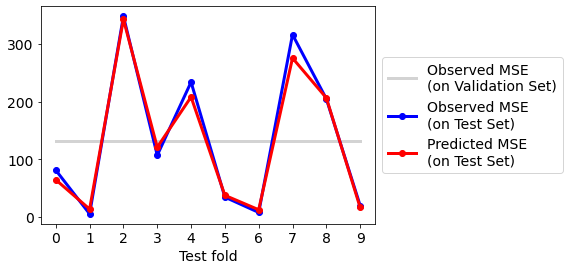

In [17]:
f, ax = plt.subplots()

ax.plot(metrics_log['valid_mse'], label='Observed MSE\n(on Validation Set)', lw=3, color='lightgrey')
ax.plot(metrics_log['true_mse'], 'o-', label='Observed MSE\n(on Test Set)', lw=3, color='blue')
ax.plot(metrics_log['pred_se_mse'], 'o-', label='Predicted MSE\n(on Test Set)', lw=3, color='red')

ax.set_xticks(range(10))
ax.set_xlabel('Test fold', fontsize=14)

ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14)

f.savefig('mse_obs_vs_pred.png', dpi=200, bbox_inches='tight')

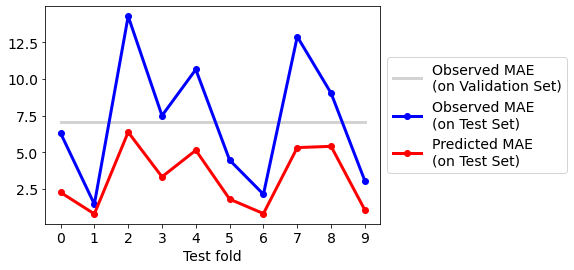

In [18]:
f, ax = plt.subplots()

ax.plot(metrics_log['valid_mae'], label='Observed MAE\n(on Validation Set)', lw=3, color='lightgrey')
ax.plot(metrics_log['true_mae'], 'o-', label='Observed MAE\n(on Test Set)', lw=3, color='blue')
ax.plot(metrics_log['pred_e_mae'], 'o-', label='Predicted MAE\n(on Test Set)', lw=3, color='red')

ax.set_xticks(range(10))
ax.set_xlabel('Test fold', fontsize=14)

ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14)

f.savefig('mae_obs_vs_pred_se.png', dpi=200, bbox_inches='tight')

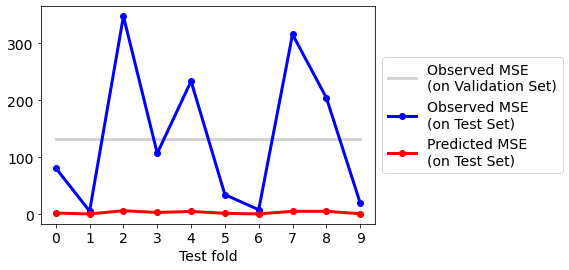

In [19]:
f, ax = plt.subplots()

ax.plot(metrics_log['valid_mse'], label='Observed MSE\n(on Validation Set)', lw=3, color='lightgrey')
ax.plot(metrics_log['true_mse'], 'o-', label='Observed MSE\n(on Test Set)', lw=3, color='blue')
ax.plot(metrics_log['pred_e_mse'], 'o-', label='Predicted MSE\n(on Test Set)', lw=3, color='red')

ax.set_xticks(range(10))
ax.set_xlabel('Test fold', fontsize=14)

ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14)

f.savefig('mse_obs_vs_pred_se.png', dpi=200, bbox_inches='tight')